In [4]:
import json
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler

from sklearn.feature_selection import SelectKBest

from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  GradientBoostingRegressor

# KDD

In [5]:
attributes = ['name', 'abv', 'ibu', 'target_fg',
              'target_og', 'ebc', 'srm', 'ph']

beer_df = pd.read_json('punk_ds.json')
beer_df = beer_df[attributes]

numeric_atts = beer_df.select_dtypes(include=[np.number]).columns

beer_df

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
0,Buzz,4.5,60.0,1010.0,1044.0,20.0,10.0,4.4
1,Trashy Blonde,4.1,41.5,1010.0,1041.7,15.0,15.0,4.4
2,Berliner Weisse With Yuzu - B-Sides,4.2,8.0,1007.0,1040.0,8.0,4.0,3.2
3,Pilsen Lager,6.3,55.0,1012.0,1060.0,30.0,15.0,4.4
4,Avery Brown Dredge,7.2,59.0,1027.0,1069.0,10.0,5.0,4.4
...,...,...,...,...,...,...,...,...
320,Jinx Pale Ale,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6
321,Jet Trash,6.9,65.0,1008.0,1060.0,18.0,9.0,4.6
322,Interstate Vienna Lager.,5.0,25.0,1007.0,1045.0,14.0,7.0,4.2
323,Fools Gold Dortmunder Lager,5.6,32.0,1009.0,1052.0,11.0,6.0,4.2


In [6]:
beer_df.dtypes

name          object
abv          float64
ibu          float64
target_fg    float64
target_og    float64
ebc          float64
srm          float64
ph           float64
dtype: object

### Estatisticas da base de dados

In [7]:
beer_df[attributes].describe().T

,count,mean,std,min,25%,50%,75%,max
abv,325.0,7.906462,4.682521,0.5,5.200,7.2,9.0,55.0
ibu,320.0,65.243750,92.403699,0.0,35.000,50.0,70.0,1157.0
target_fg,324.0,1015.169753,14.488349,1000.0,1010.000,1012.0,1015.0,1125.0
target_og,324.0,1067.530556,27.142109,1007.0,1048.375,1065.0,1080.0,1157.0
ebc,319.0,66.228527,92.306210,2.0,15.000,28.0,70.5,600.0
srm,319.0,33.581881,46.505684,1.0,8.000,15.0,40.0,305.0
ph,323.0,4.641486,4.166788,3.2,4.400,4.4,4.4,79.0


**Empty Values**

Quantidade de campos vazios de cada atributo

In [8]:
print(beer_df.shape)
beer_df.isna().sum()

(325, 8)


name         0
abv          0
ibu          5
target_fg    1
target_og    1
ebc          6
srm          6
ph           2
dtype: int64

In [9]:
# Remove rows with empty IBU
beer_df = beer_df.dropna(subset=['ibu'])

# Replace empty rows with using the average
beer_df = beer_df.fillna(beer_df.mean())

print(beer_df.shape)
beer_df.isna().sum()

(320, 8)


name         0
abv          0
ibu          0
target_fg    0
target_og    0
ebc          0
srm          0
ph           0
dtype: int64

Removemos 5 instancias que estavam com IBU vazio.

**Histogram de cada atributo numerico**

array([[<AxesSubplot:title={'center':'abv'}>,
        <AxesSubplot:title={'center':'ibu'}>,
        <AxesSubplot:title={'center':'target_fg'}>,
        <AxesSubplot:title={'center':'target_og'}>],
       [<AxesSubplot:title={'center':'ebc'}>,
        <AxesSubplot:title={'center':'srm'}>,
        <AxesSubplot:title={'center':'ph'}>, <AxesSubplot:>]],
      dtype=object)

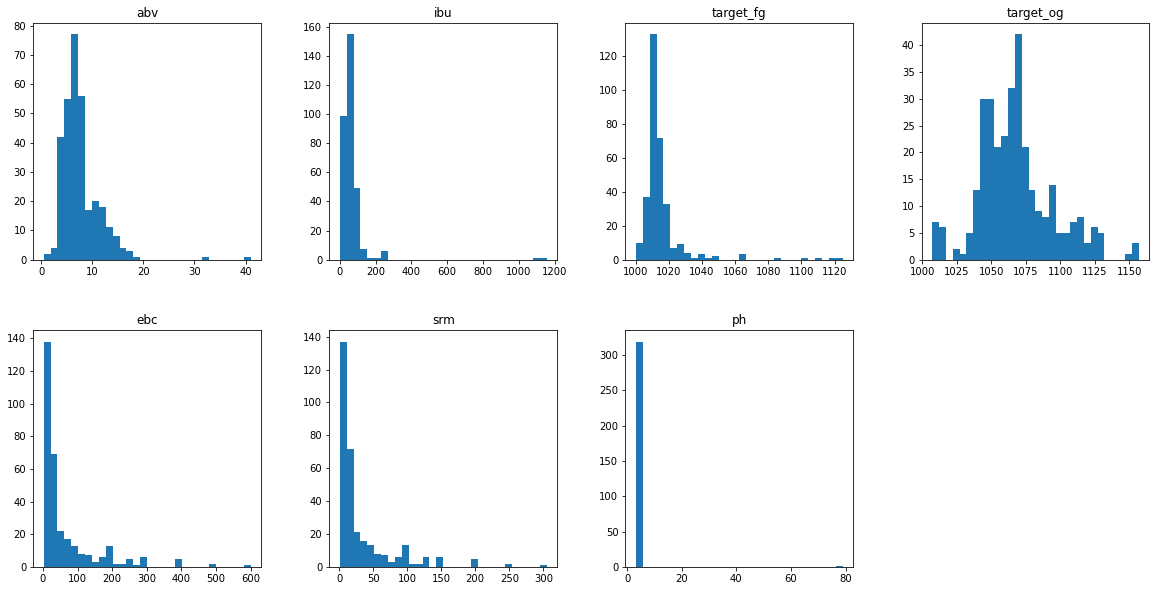

In [10]:
beer_df[numeric_atts].hist(figsize=(20,10), grid=False, layout=(2, 4), bins = 30)

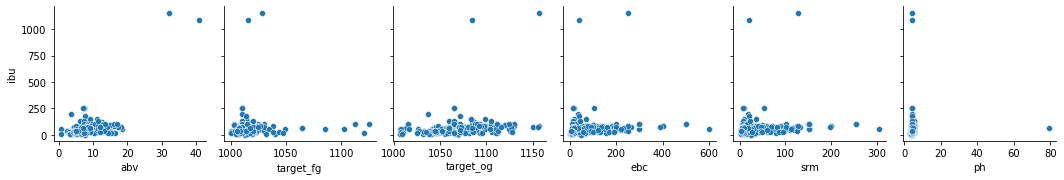

In [11]:
pp = sns.pairplot(data=beer_df,
                  y_vars=['ibu'],
                  x_vars=['abv', 'target_fg', 'target_og',
                          'ebc', 'srm', 'ph'])


Olhando para o grafico acima podemos observar que duas instancias aparecem com IBU bastante elevado quando comparada com as outras instancias. 

Um fenomeno similar ocorre no PH, mas nesse caso ocorre com apenas uma instancia.

Essas instancias dificultam a analise do grafico de pares. Dessa forma iremos remove-las da base manualmente e posteriormente iremos utilizar tecnicas mais robustas para remocao de outilers.

Posteriormente iremos investigar melhor os outilies em todo dataset e analisar o impacto no modelo.

In [12]:
beer_no_out_df = beer_df[((beer_df['ibu'] < 500) & (beer_df['ph'] < 20))]
beer_no_out_df.shape

(317, 8)

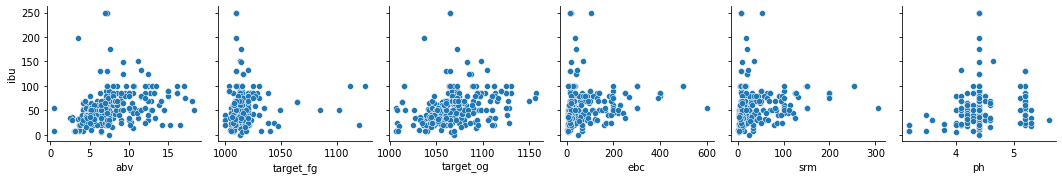

In [13]:
pp = sns.pairplot(data=beer_no_out_df,
                  y_vars=['ibu'],
                  x_vars=['abv', 'target_fg', 'target_og',
                          'ebc', 'srm', 'ph'])

Apos a remocao das tres instancias, podemos visualizar melhor a correlacao de cada atributo com o IBU. Porem, ainda  é possivel observar alguns pontos que parecem ser outliers. Isso reforca a intuicao de que poderiamos utilizar um metodo de remocao de outliers mais robusto.

**Matriz de Correlacao**

<AxesSubplot:>

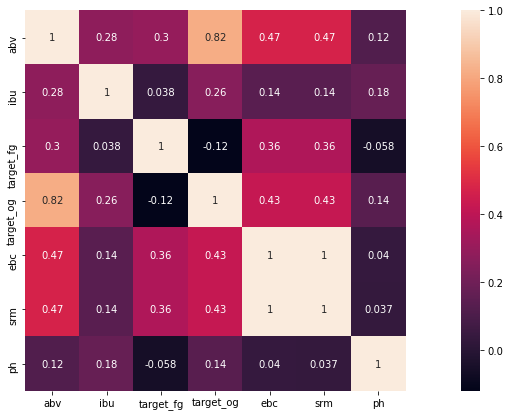

In [14]:
plt.figure(figsize=(20,7))
sns.heatmap(beer_no_out_df[numeric_atts].corr(), annot=True, square=True)

O grafico acima mostra que os atributos que tem mais relacao com o IBU sao o ABV e Target OG, apesar que ser uma relacao fraca quando comparada com as relacoes EBC x SRM e ABV x Target OG. 

# Train a ML Model to predict the IBU

In [15]:
# KFold Split
X_att = ['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']

X = beer_no_out_df[X_att].values
X = StandardScaler().fit_transform(X)
Y = beer_no_out_df['ibu'].values

### Train and Test Resgresssion Models

In [16]:
def predict_ipu(algorithm, X, Y):
    kf = KFold(n_splits=2, random_state=0, shuffle=True)

    feature_importances = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Train the model using the training sets
        algorithm.fit(X_train, Y_train)
        
        if (isinstance(algorithm, GradientBoostingRegressor) or
            isinstance(algorithm, RandomForestRegressor)):
            feature_importances.append(algorithm.feature_importances_)

        Y_pred = algorithm.predict(X_test)
        
        # The mean squared error
        print('Mean squared error: %.2f'
              % mean_squared_error(Y_test, Y_pred))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: %.2f'
              % r2_score(Y_test, Y_pred))
        
#         for test, pred in zip(Y_test, Y_pred):
#             print(test, pred)
   
    print('\n')

    return np.array(feature_importances).mean(axis=0)
 
    
predict_ipu(LinearRegression(normalize=True), X, Y)

predict_ipu(KNeighborsRegressor(n_neighbors = 4), X, Y)

gbr_feature_importances = predict_ipu(GradientBoostingRegressor(), X, Y)

rdf_feature_importances = predict_ipu(RandomForestRegressor(), X, Y)

Mean squared error: 1594.05
Coefficient of determination: 0.08
Mean squared error: 1199.66
Coefficient of determination: 0.04


Mean squared error: 1158.70
Coefficient of determination: 0.33
Mean squared error: 1758.91
Coefficient of determination: -0.40




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: Mean of empty slice.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: Mean of empty slice.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean squared error: 971.80
Coefficient of determination: 0.44
Mean squared error: 1412.80
Coefficient of determination: -0.13


Mean squared error: 909.72
Coefficient of determination: 0.48
Mean squared error: 1131.29
Coefficient of determination: 0.10




In [17]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')

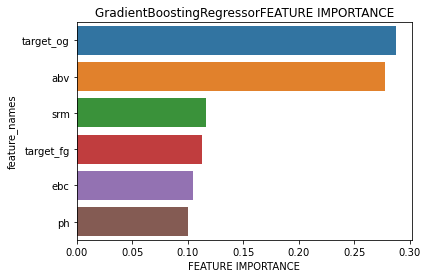

In [18]:
plot_feature_importance(gbr_feature_importances, X_att, 'GradientBoostingRegressor')

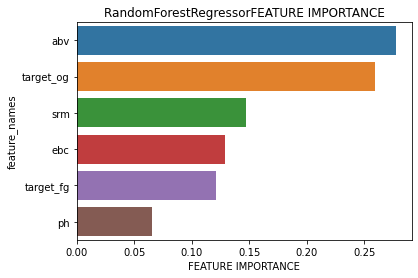

In [19]:
plot_feature_importance(rdf_feature_importances, X_att, 'RandomForestRegressor')

# Remoção de Outilers

Como mencionado anteriormente, algumas instancias parecem ser outilers. O grafico abaixo ilustra essa hipotese.

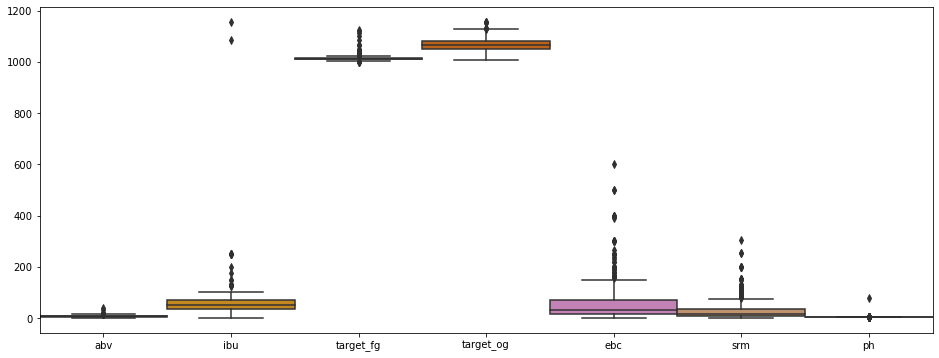

In [20]:
plt.figure(figsize=(16, 6))
bplot = sns.boxplot(data=beer_df[numeric_atts], 
                    width=1,
                    palette="colorblind")

Desta forma, vamos utilizar o IQR para os outilers e analisar se o resultado se ha melhora no resultado dos experimentos.

In [21]:
Q1 = beer_df.quantile(0.25)
Q3 = beer_df.quantile(0.75)
IQR = Q3 - Q1

beer_noout_df = beer_df[~((beer_df < (Q1 - 1.5 * IQR)) |
                          (beer_df > (Q3 + 1.5 * IQR))).any(axis=1)]

beer_noout_df.shape

(138, 8)

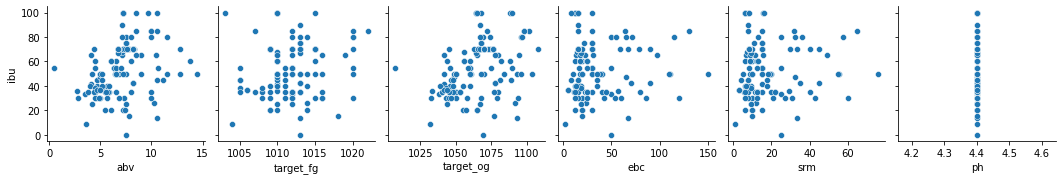

In [22]:
pp = sns.pairplot(data=beer_noout_df,
                  y_vars=['ibu'],
                  x_vars=['abv', 'target_fg', 'target_og',
                          'ebc', 'srm', 'ph'])

<AxesSubplot:>

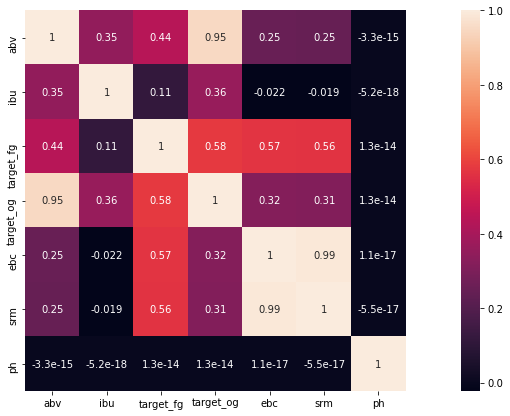

In [23]:
plt.figure(figsize=(20,7))
sns.heatmap(beer_noout_df[numeric_atts].corr(), annot=True, square=True)

In [24]:
X = beer_noout_df[X_att].values
X = StandardScaler().fit_transform(X)
Y = beer_noout_df['ibu'].values

In [25]:
gbr_feature_importances = predict_ipu(GradientBoostingRegressor(), X, Y)

rdf_feature_importances = predict_ipu(RandomForestRegressor(), X, Y)

Mean squared error: 823.02
Coefficient of determination: -0.76
Mean squared error: 374.23
Coefficient of determination: 0.18


Mean squared error: 569.56
Coefficient of determination: -0.21
Mean squared error: 265.02
Coefficient of determination: 0.42




**Using other method to remove outlier** 

In [26]:
df = beer_df.copy()

for _att in numeric_atts:
    att = df[_att]
    removed_outliers = att.between(att.quantile(.05), att.quantile(.95))
    index_names = df[~removed_outliers].index
    df.drop(index_names, inplace=True)
# df = df[~((df < df.quantile(.05)) |
#           (df > df.quantile(.95))).any(axis=1)]

print('Original dataset:', len(beer_df))
print('Dataset after outlier removal:', len(df))

Original dataset: 320
Dataset after outlier removal: 175


In [27]:
X = df[X_att].values
X = StandardScaler().fit_transform(X)
Y = df['ibu'].values

gbr_feature_importances = predict_ipu(GradientBoostingRegressor(), X, Y)

rdf_feature_importances = predict_ipu(RandomForestRegressor(), X, Y)

Mean squared error: 382.94
Coefficient of determination: 0.11
Mean squared error: 330.20
Coefficient of determination: 0.10


Mean squared error: 343.54
Coefficient of determination: 0.20
Mean squared error: 254.55
Coefficient of determination: 0.31


